# Banking Intent Classification

Multi-class intent classification for banking customer support using:
- Traditional ML models (sklearn)
- BERT Transformer (GPU-accelerated)

**Dataset**: PolyAI Banking Dataset (77 intents, 13K+ samples)

## 1. Setup & Dependencies

In [1]:
pip install kagglehub wordcloud contractions -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.7 MB/s eta 0:00:00


In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import joblib
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions

# Sklearn - Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier

# Sklearn - Preprocessing & Evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6
Memory Allocated: 0.00 MB
Memory Cached: 0.00 MB


In [4]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Create directories for saving models
os.makedirs('saved_models/bert_banking_intent', exist_ok=True)
print("Directories created for model saving")

Directories created for model saving


## 2. Data Loading

### 2.1 Download Dataset

In [5]:
train_url = "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv"
test_url = "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv"

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

# print(train_df.head())

# save to csv
train_df.to_csv("banking_train.csv", index=False)
test_df.to_csv("banking_test.csv", index=False)

In [6]:
# Load banking dataset
train_df = pd.read_csv('banking_train.csv')
test_df = pd.read_csv('banking_test.csv')

print(f"Training set: {train_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"Number of intents: {train_df['category'].nunique()}")

train_df.head()

Training set: 10003 samples
Test set: 3080 samples

Columns: ['text', 'category']
Number of intents: 77


,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [7]:
# Dataset statistics
print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)

print(f"\nTraining Set:")
print(f"  - Total samples: {len(train_df)}")
print(f"  - Unique intents: {train_df['category'].nunique()}")
print(f"  - Avg text length: {train_df['text'].str.len().mean():.1f} chars")
print(f"  - Avg word count: {train_df['text'].str.split().str.len().mean():.1f} words")

print(f"\nTest Set:")
print(f"  - Total samples: {len(test_df)}")
print(f"  - Unique intents: {test_df['category'].nunique()}")

# Check for missing values
print(f"\nMissing values (train): {train_df.isnull().sum().sum()}")
print(f"Missing values (test): {test_df.isnull().sum().sum()}")

DATASET STATISTICS

Training Set:
  - Total samples: 10003
  - Unique intents: 77
  - Avg text length: 59.5 chars
  - Avg word count: 11.9 words

Test Set:
  - Total samples: 3080
  - Unique intents: 77

Missing values (train): 0
Missing values (test): 0


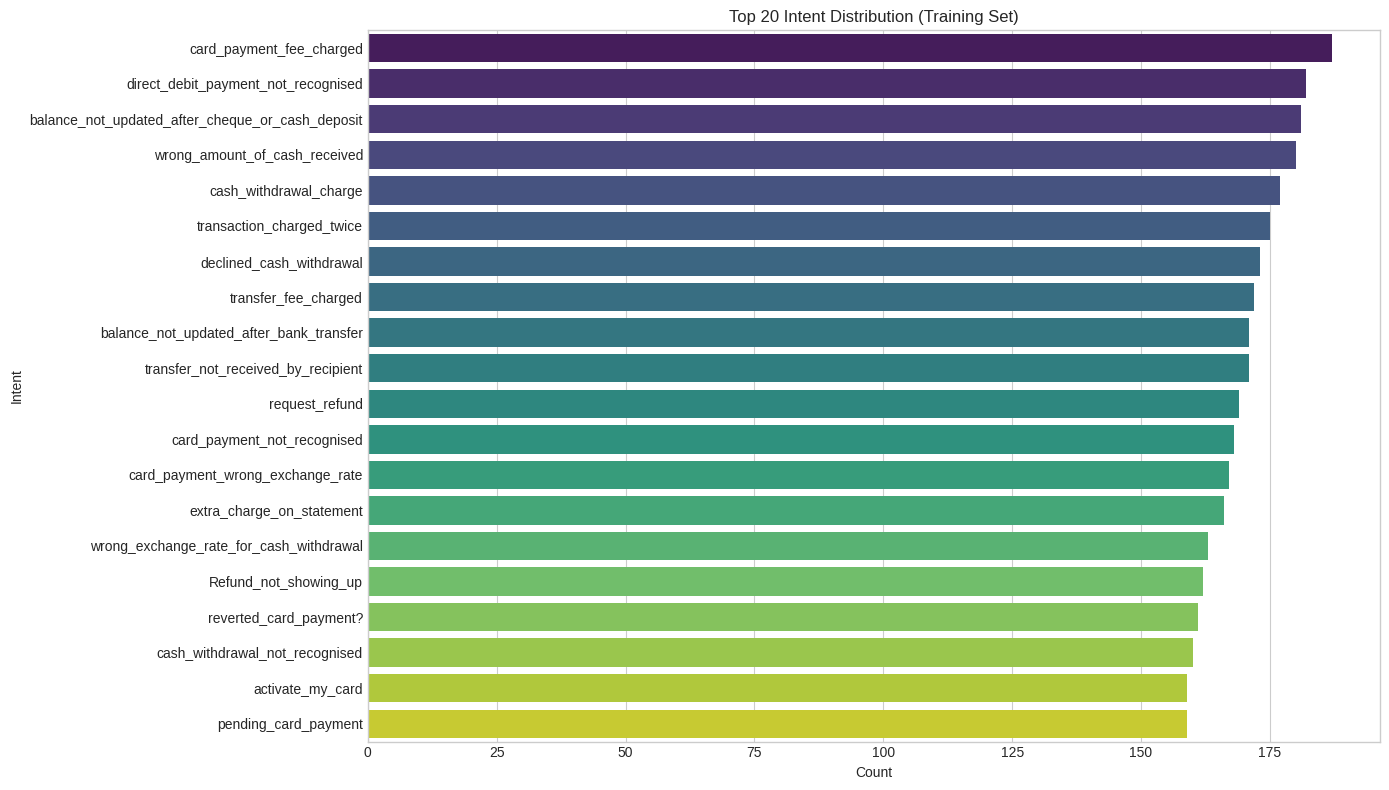

In [8]:
# Visualize intent distribution (top 20)
plt.figure(figsize=(14, 8))
intent_counts = train_df['category'].value_counts().head(20)
sns.barplot(x=intent_counts.values, y=intent_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.title('Top 20 Intent Distribution (Training Set)')
plt.tight_layout()
plt.show()

## 3. Text Preprocessing

In [9]:
# Text preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Clean and preprocess text for ML models."""
    # Convert to lowercase
    text = str(text).lower()

    # Expand contractions
    text = contractions.fix(text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(tokens)

# Test preprocessing
sample_text = "I can't access my account! What's happening with my card?"
print(f"Original: {sample_text}")
print(f"Processed: {preprocess_text(sample_text)}")

Original: I can't access my account! What's happening with my card?
Processed: access account happening card


In [10]:
# Apply preprocessing to datasets
print("Preprocessing text...")
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
test_df['text_clean'] = test_df['text'].apply(preprocess_text)
print("Preprocessing complete!")

# Show sample
print("\nSample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {train_df['text'].iloc[i]}")
    print(f"Cleaned: {train_df['text_clean'].iloc[i]}")

Preprocessing text...
Preprocessing complete!

Sample preprocessed texts:

Original: I am still waiting on my card?
Cleaned: still waiting card

Original: What can I do if my card still hasn't arrived after 2 weeks?
Cleaned: card still arrived week

Original: I have been waiting over a week. Is the card still coming?
Cleaned: waiting week card still coming


In [11]:
# Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['category'])
test_df['label'] = label_encoder.transform(test_df['category'])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"\nSample labels: {list(label_encoder.classes_[:10])}...")

Number of classes: 77

Sample labels: ['Refund_not_showing_up', 'activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer']...


In [12]:
# Split training data into train/validation
X_train_text, X_val_text, y_train, y_val = train_test_split(
    train_df['text_clean'],
    train_df['label'],
    test_size=0.15,
    random_state=SEED,
    stratify=train_df['label']
)

X_test_text = test_df['text_clean']
y_test = test_df['label']

print(f"Training samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples: {len(X_test_text)}")

Training samples: 8502
Validation samples: 1501
Test samples: 3080


In [13]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"TF-IDF shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF shape (val): {X_val_tfidf.shape}")
print(f"TF-IDF shape (test): {X_test_tfidf.shape}")

TF-IDF shape (train): (8502, 5000)
TF-IDF shape (val): (1501, 5000)
TF-IDF shape (test): (3080, 5000)


## 4. Sklearn Models

In [14]:
# Results dictionary - will be populated after test set evaluation
results = {}
trained_models = {}

def train_model(name, model, X_train, y_train):
    """Train a sklearn model."""
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"  Training complete!")
    return model

In [15]:
# Naive Bayes
nb_model = train_model(
    "Naive Bayes",
    MultinomialNB(),
    X_train_tfidf, y_train
)


Training Naive Bayes...
  Training complete!


In [16]:
# Logistic Regression
lr_model = train_model(
    "Logistic Regression",
    LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1),
    X_train_tfidf, y_train
)


Training Logistic Regression...
  Training complete!


In [17]:
# SVM (LinearSVC)
svm_model = train_model(
    "SVM (LinearSVC)",
    LinearSVC(max_iter=1000, random_state=SEED),
    X_train_tfidf, y_train
)


Training SVM (LinearSVC)...
  Training complete!


In [18]:
# Random Forest
rf_model = train_model(
    "Random Forest",
    RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    X_train_tfidf, y_train
)


Training Random Forest...
  Training complete!


In [19]:
# MLP Classifier (Neural Network with sklearn)
mlp_model = train_model(
    "MLP Classifier",
    MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=SEED
    ),
    X_train_tfidf, y_train
)


Training MLP Classifier...
  Training complete!


## 5. Ensemble Models

In [20]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression(max_iter=1000, random_state=SEED)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)),
        ('svm', LinearSVC(max_iter=1000, random_state=SEED))
    ],
    voting='hard'
)

voting_model = train_model(
    "Voting Classifier",
    voting_clf,
    X_train_tfidf, y_train
)


Training Voting Classifier...
  Training complete!


In [21]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression(max_iter=1000, random_state=SEED)),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=SEED, n_jobs=-1)),
        ('svm', LinearSVC(max_iter=1000, random_state=SEED))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=SEED),
    cv=3,
    n_jobs=-1
)

stacking_model = train_model(
    "Stacking Classifier",
    stacking_clf,
    X_train_tfidf, y_train
)


Training Stacking Classifier...
  Training complete!


## 6. BERT Transformer Model

In [22]:
# Load BERT tokenizer
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f"Loaded tokenizer: {MODEL_NAME}")
print(f"Vocab size: {tokenizer.vocab_size}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loaded tokenizer: bert-base-uncased
Vocab size: 30522


In [23]:
# Prepare datasets for BERT (using original text, not preprocessed)
# BERT has its own tokenization

# Re-split using original text for BERT
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.15,
    random_state=SEED,
    stratify=train_df['label']
)

X_test_bert = test_df['text'].tolist()
y_test_bert = test_df['label'].tolist()

print(f"BERT Train: {len(X_train_bert)}")
print(f"BERT Val: {len(X_val_bert)}")
print(f"BERT Test: {len(X_test_bert)}")

BERT Train: 8502
BERT Val: 1501
BERT Test: 3080


In [24]:
# Create Hugging Face datasets
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Create datasets
train_dataset = HFDataset.from_dict({'text': X_train_bert, 'label': y_train_bert})
val_dataset = HFDataset.from_dict({'text': X_val_bert, 'label': y_val_bert})
test_dataset = HFDataset.from_dict({'text': X_test_bert, 'label': y_test_bert})

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("Datasets prepared for BERT training")

Map:   0%|          | 0/8502 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Datasets prepared for BERT training


In [25]:
# Load BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes
)

# Move model to GPU
bert_model = bert_model.to(device)
print(f"Model loaded on: {device}")
print(f"Model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda
Model parameters: 109,541,453


In [26]:
# Compute metrics function for Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    dataloader_num_workers=2,
    report_to='none'  # Disable wandb/tensorboard
)

# Initialize Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Trainer initialized")

Trainer initialized


In [28]:
# Train BERT model
print("Starting BERT training...")
print("="*50)

train_result = trainer.train()

print("\nTraining complete!")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

Starting BERT training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.232700,1.502495,0.732845,0.702270,0.740785,0.732845
2,0.544800,0.482327,0.886076,0.884618,0.892656,0.886076
3,0.261000,0.368657,0.903398,0.904040,0.913423,0.903398
4,0.131000,0.376502,0.916722,0.917351,0.922895,0.916722
5,0.070800,0.388274,0.916056,0.916654,0.922778,0.916056
6,0.027200,0.406048,0.914724,0.914734,0.919999,0.914724



Training complete!
Training time: 526.32 seconds


In [29]:
# Evaluate BERT on validation set (for monitoring training)
print("\nEvaluating BERT on validation set...")
val_results = trainer.evaluate()

print(f"\nBERT Validation Results (for early stopping reference):")
print(f"  Accuracy: {val_results['eval_accuracy']:.4f}")
print(f"  F1 Score: {val_results['eval_f1']:.4f}")
print(f"  Precision: {val_results['eval_precision']:.4f}")
print(f"  Recall: {val_results['eval_recall']:.4f}")


Evaluating BERT on validation set...



BERT Validation Results (for early stopping reference):
  Accuracy: 0.9167
  F1 Score: 0.9174
  Precision: 0.9229
  Recall: 0.9167


## 7. Test Set Evaluation & Results Comparison

In [30]:
# Evaluate ALL sklearn models on TEST set
print("Evaluating all models on TEST set...")
print("="*50)

for name, model in trained_models.items():
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")

# Evaluate BERT on test set
print("\n" + "="*50)
print("Evaluating BERT on TEST set...")
bert_test_results = trainer.evaluate(test_dataset)

results['BERT'] = {
    'model': bert_model,
    'accuracy': bert_test_results['eval_accuracy'],
    'precision': bert_test_results['eval_precision'],
    'recall': bert_test_results['eval_recall'],
    'f1_score': bert_test_results['eval_f1']
}

print(f"\nBERT:")
print(f"  Accuracy: {bert_test_results['eval_accuracy']:.4f}")
print(f"  F1 Score: {bert_test_results['eval_f1']:.4f}")

Evaluating all models on TEST set...

Naive Bayes:
  Accuracy: 0.7932
  F1 Score: 0.7841

Logistic Regression:
  Accuracy: 0.8305
  F1 Score: 0.8296

SVM (LinearSVC):
  Accuracy: 0.8539
  F1 Score: 0.8539

Random Forest:
  Accuracy: 0.8282
  F1 Score: 0.8278

MLP Classifier:
  Accuracy: 0.8409
  F1 Score: 0.8404

Voting Classifier:
  Accuracy: 0.8442
  F1 Score: 0.8434

Stacking Classifier:
  Accuracy: 0.8747
  F1 Score: 0.8745

Evaluating BERT on TEST set...



BERT:
  Accuracy: 0.9247
  F1 Score: 0.9248


In [31]:
# Create results DataFrame (based on TEST set evaluation)
results_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': data['accuracy'],
        'Precision': data['precision'],
        'Recall': data['recall'],
        'F1 Score': data['f1_score']
    }
    for name, data in results.items()
]).sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("MODEL COMPARISON ON TEST SET (Sorted by F1 Score)")
print("="*70)
print(results_df.to_string(index=False))


MODEL COMPARISON ON TEST SET (Sorted by F1 Score)
              Model  Accuracy  Precision   Recall  F1 Score
               BERT  0.924675   0.928466 0.924675  0.924754
Stacking Classifier  0.874675   0.877929 0.874675  0.874514
    SVM (LinearSVC)  0.853896   0.858541 0.853896  0.853903
  Voting Classifier  0.844156   0.852854 0.844156  0.843438
     MLP Classifier  0.840909   0.850009 0.840909  0.840388
Logistic Regression  0.830519   0.841630 0.830519  0.829623
      Random Forest  0.828247   0.834846 0.828247  0.827796
        Naive Bayes  0.793182   0.810146 0.793182  0.784121


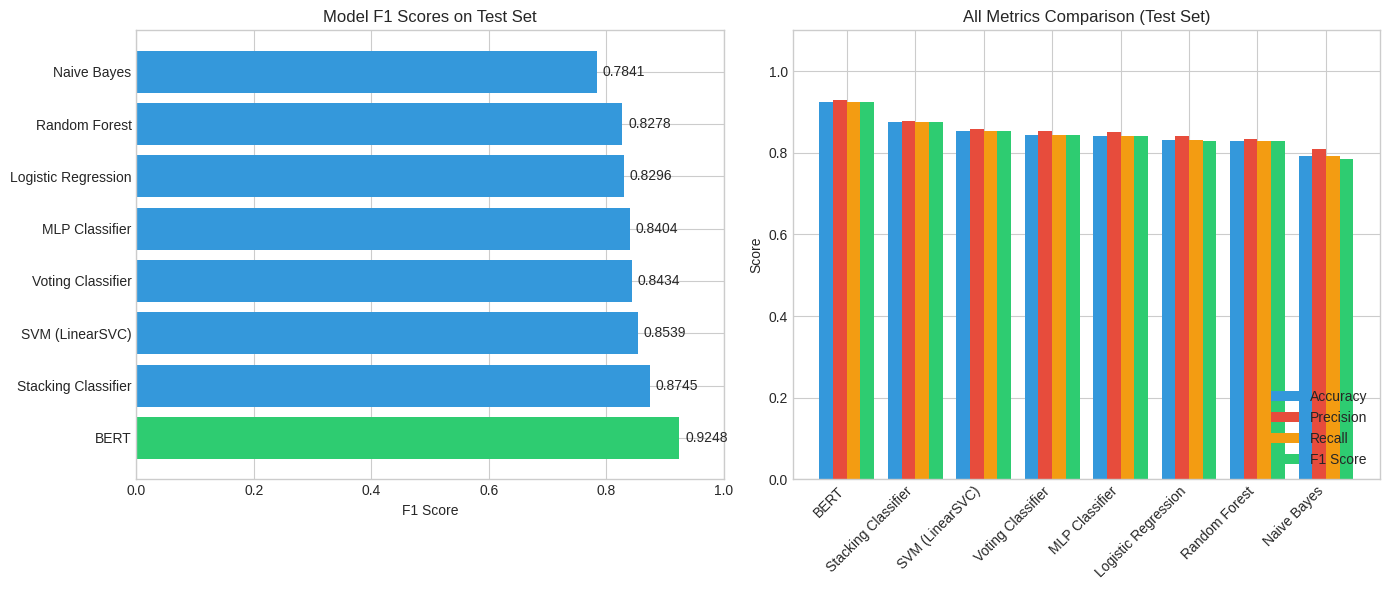

In [32]:
# Visualize results (TEST set)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of F1 scores
colors = ['#2ecc71' if x == results_df['F1 Score'].max() else '#3498db' for x in results_df['F1 Score']]
ax1 = axes[0]
bars = ax1.barh(results_df['Model'], results_df['F1 Score'], color=colors)
ax1.set_xlabel('F1 Score')
ax1.set_title('Model F1 Scores on Test Set')
ax1.set_xlim(0, 1)
for bar, score in zip(bars, results_df['F1 Score']):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

# Grouped bar plot for all metrics
ax2 = axes[1]
x = np.arange(len(results_df))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax2.bar(x + i*width, results_df[metric], width, label=metric, color=color)

ax2.set_ylabel('Score')
ax2.set_title('All Metrics Comparison (Test Set)')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## 8. Detailed Classification Reports

In [33]:
# Find best models
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1 Score']

# Best sklearn model (excluding BERT)
sklearn_results = results_df[results_df['Model'] != 'BERT']
best_sklearn_name = sklearn_results.iloc[0]['Model']
best_sklearn_f1 = sklearn_results.iloc[0]['F1 Score']

print(f"Best Overall Model: {best_model_name} (F1: {best_f1:.4f})")
print(f"Best Sklearn Model: {best_sklearn_name} (F1: {best_sklearn_f1:.4f})")

Best Overall Model: BERT (F1: 0.9248)
Best Sklearn Model: Stacking Classifier (F1: 0.8745)


In [34]:
# Best sklearn model classification report
print(f"\n{'='*70}")
print(f"Classification Report: {best_sklearn_name}")
print(f"{'='*70}")

best_sklearn_model = results[best_sklearn_name]['model']
y_pred_sklearn = best_sklearn_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_sklearn, target_names=label_encoder.classes_, zero_division=0))


Classification Report: Stacking Classifier
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.86      0.93      0.89        40
                                activate_my_card       0.97      0.93      0.95        40
                                       age_limit       0.98      1.00      0.99        40
                         apple_pay_or_google_pay       1.00      0.97      0.99        40
                                     atm_support       0.92      0.88      0.90        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.74      0.70      0.72        40
balance_not_updated_after_cheque_or_cash_deposit       0.90      0.90      0.90        40
                         beneficiary_not_allowed       0.87      0.85      0.86        40
                                 cancel_transfer       

In [35]:
# BERT classification report
print(f"\n{'='*70}")
print("Classification Report: BERT")
print(f"{'='*70}")

bert_predictions = trainer.predict(test_dataset)
y_pred_bert = bert_predictions.predictions.argmax(-1)

print(classification_report(y_test_bert, y_pred_bert, target_names=label_encoder.classes_, zero_division=0))


Classification Report: BERT


                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       1.00      0.97      0.99        40
                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       0.98      1.00      0.99        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.95      1.00      0.98        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.84      0.80      0.82        40
balance_not_updated_after_cheque_or_cash_deposit       1.00      0.95      0.97        40
                         beneficiary_not_allowed       0.93      0.95      0.94        40
                                 cancel_transfer       1.00      0.93      0.96        40
         

In [40]:
import numpy as np

# Get the number of classes
num_classes = len(label_encoder.classes_)

print("True Positive Rate (TPR) and False Positive Rate (FPR) per Class (BERT Model):")
print("-" * 90)

tpr_fpr_results = []

for i, class_name in enumerate(label_encoder.classes_):
    # True Positives: diagonal element for the current class
    TP = cm[i, i]

    # False Negatives: sum of the current row excluding TP
    FN = np.sum(cm[i, :]) - TP

    # False Positives: sum of the current column excluding TP
    FP = np.sum(cm[:, i]) - TP

    # True Negatives: sum of all elements excluding the current row and column
    TN = np.sum(cm) - (TP + FP + FN)

    # Calculate TPR (Recall)
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate FPR
    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0

    tpr_fpr_results.append({
        'Class': class_name,
        'TPR (Recall)': tpr,
        'FPR': fpr
    })

    print(f"Class: {class_name:<40} | TPR (Recall): {tpr:.4f} | FPR: {fpr:.4f}")

print("-" * 90)


True Positive Rate (TPR) and False Positive Rate (FPR) per Class (BERT Model):
------------------------------------------------------------------------------------------
Class: Refund_not_showing_up                    | TPR (Recall): 0.9750 | FPR: 0.0000
Class: activate_my_card                         | TPR (Recall): 0.9500 | FPR: 0.0000
Class: age_limit                                | TPR (Recall): 1.0000 | FPR: 0.0003
Class: apple_pay_or_google_pay                  | TPR (Recall): 1.0000 | FPR: 0.0000
Class: atm_support                              | TPR (Recall): 1.0000 | FPR: 0.0007
Class: automatic_top_up                         | TPR (Recall): 0.9000 | FPR: 0.0000
Class: balance_not_updated_after_bank_transfer  | TPR (Recall): 0.8000 | FPR: 0.0020
Class: balance_not_updated_after_cheque_or_cash_deposit | TPR (Recall): 0.9500 | FPR: 0.0000
Class: beneficiary_not_allowed                  | TPR (Recall): 0.9500 | FPR: 0.0010
Class: cancel_transfer                          | TPR (Re

The output above shows the True Positive Rate (TPR), also known as Recall, and the False Positive Rate (FPR) for each of the 77 banking intent classes.

- **True Positive Rate (TPR)**: Indicates the proportion of actual positive cases that were correctly identified. A high TPR means the model is good at detecting the positive class.
- **False Positive Rate (FPR)**: Indicates the proportion of actual negative cases that were incorrectly identified as positive. A low FPR means the model doesn't frequently misclassify negative instances as positive.

These metrics are crucial for understanding class-specific performance, especially in imbalanced datasets or when the cost of different types of errors varies.

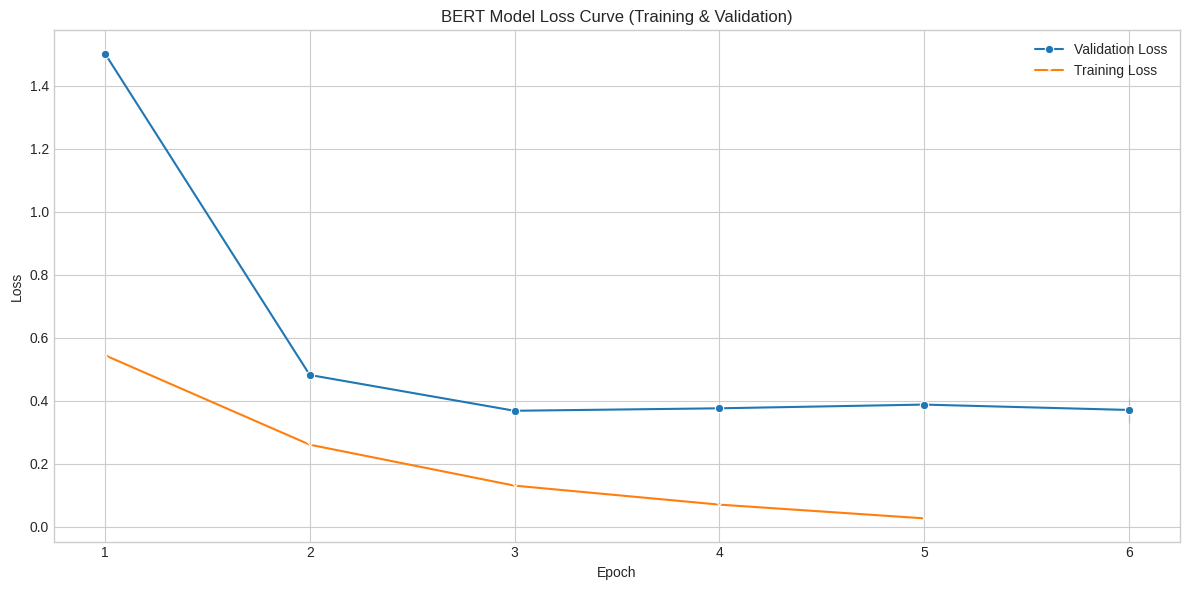

In [48]:
# Extract training history from the Trainer object
log_history = trainer.state.log_history

# Filter for epoch-level logs (which contain evaluation metrics and sometimes final training loss for the epoch)
epochs = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

# To store all individual training step losses and their fractional epochs
all_train_steps_data = []

for log in log_history:
    if 'eval_loss' in log and 'epoch' in log:
        # This is an evaluation log entry for a full epoch
        epochs.append(log['epoch'])
        val_losses.append(log['eval_loss'])
        val_accuracies.append(log['eval_accuracy'])
        val_f1_scores.append(log['eval_f1'])
        val_precisions.append(log['eval_precision'])
        val_recalls.append(log['eval_recall'])
    elif 'loss' in log and 'eval_loss' not in log and 'epoch' in log:
        # This is a training step log, collect its data
        all_train_steps_data.append({'epoch_float': log['epoch'], 'loss': log['loss']})

# Combine validation data into a DataFrame
history_df = pd.DataFrame({
    'epoch': epochs,
    'validation_loss': val_losses,
    'validation_accuracy': val_accuracies,
    'validation_f1': val_f1_scores,
    'validation_precision': val_precisions,
    'validation_recall': val_recalls
})

# Process training step data to get the last loss per *integer* epoch
train_steps_df = pd.DataFrame(all_train_steps_data)
if not train_steps_df.empty:
    train_steps_df['integer_epoch'] = train_steps_df['epoch_float'].apply(np.floor)
    # Get the last reported training loss for each full (integer) epoch
    # Assuming the logs are generally ordered by epoch_float, .last() will give the closest to the end of the integer epoch.
    last_train_loss_per_integer_epoch = train_steps_df.groupby('integer_epoch')['loss'].last().reset_index()

    # Align training losses with the unique validation epochs
    unique_val_epochs_for_plot = history_df['epoch'].unique()
    aligned_train_losses_for_plot = []

    for val_epoch_num in unique_val_epochs_for_plot:
        int_val_epoch_num = np.floor(val_epoch_num)
        matching_loss_row = last_train_loss_per_integer_epoch[
            last_train_loss_per_integer_epoch['integer_epoch'] == int_val_epoch_num
        ]
        if not matching_loss_row.empty:
            aligned_train_losses_for_plot.append(matching_loss_row['loss'].iloc[0])
        else:
            aligned_train_losses_for_plot.append(np.nan) # No training loss found for this integer epoch

    # Create a DataFrame for plotting training loss
    train_loss_plot_df = pd.DataFrame({
        'epoch': unique_val_epochs_for_plot,
        'training_loss': aligned_train_losses_for_plot
    })

# Plotting the Loss Curve
plt.figure(figsize=(12, 6))
sns.lineplot(x='epoch', y='validation_loss', data=history_df, label='Validation Loss', marker='o')

# Only plot training loss if we have data for it
if not train_steps_df.empty and 'train_loss_plot_df' in locals() and not train_loss_plot_df['training_loss'].isnull().all():
    sns.lineplot(x='epoch', y='training_loss', data=train_loss_plot_df.dropna(subset=['training_loss']), label='Training Loss', marker='x')

plt.title('BERT Model Loss Curve (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This plot shows how the training loss and validation loss evolved over each epoch. Ideally, both curves should decrease, and the validation loss should not significantly diverge from the training loss, which would indicate overfitting.

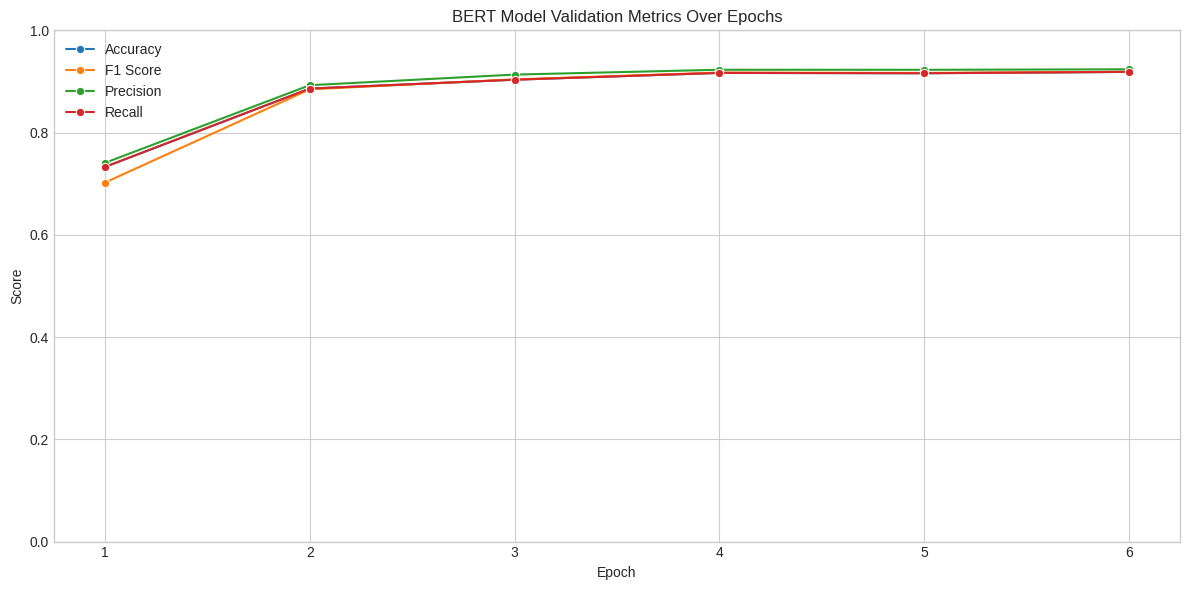

In [39]:
# Plotting the Evaluation Metrics Curve
plt.figure(figsize=(12, 6))

sns.lineplot(x='epoch', y='validation_accuracy', data=history_df, label='Accuracy', marker='o')
sns.lineplot(x='epoch', y='validation_f1', data=history_df, label='F1 Score', marker='o')
sns.lineplot(x='epoch', y='validation_precision', data=history_df, label='Precision', marker='o')
sns.lineplot(x='epoch', y='validation_recall', data=history_df, label='Recall', marker='o')

plt.title('BERT Model Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are usually between 0 and 1
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This plot illustrates the performance of the BERT model on the validation set for key metrics (Accuracy, F1-Score, Precision, Recall) across each training epoch. Observing these curves helps understand how well the model generalizes and if its performance stabilizes or starts to degrade (e.g., due to overfitting) over time. An increasing trend for these metrics indicates improved performance.

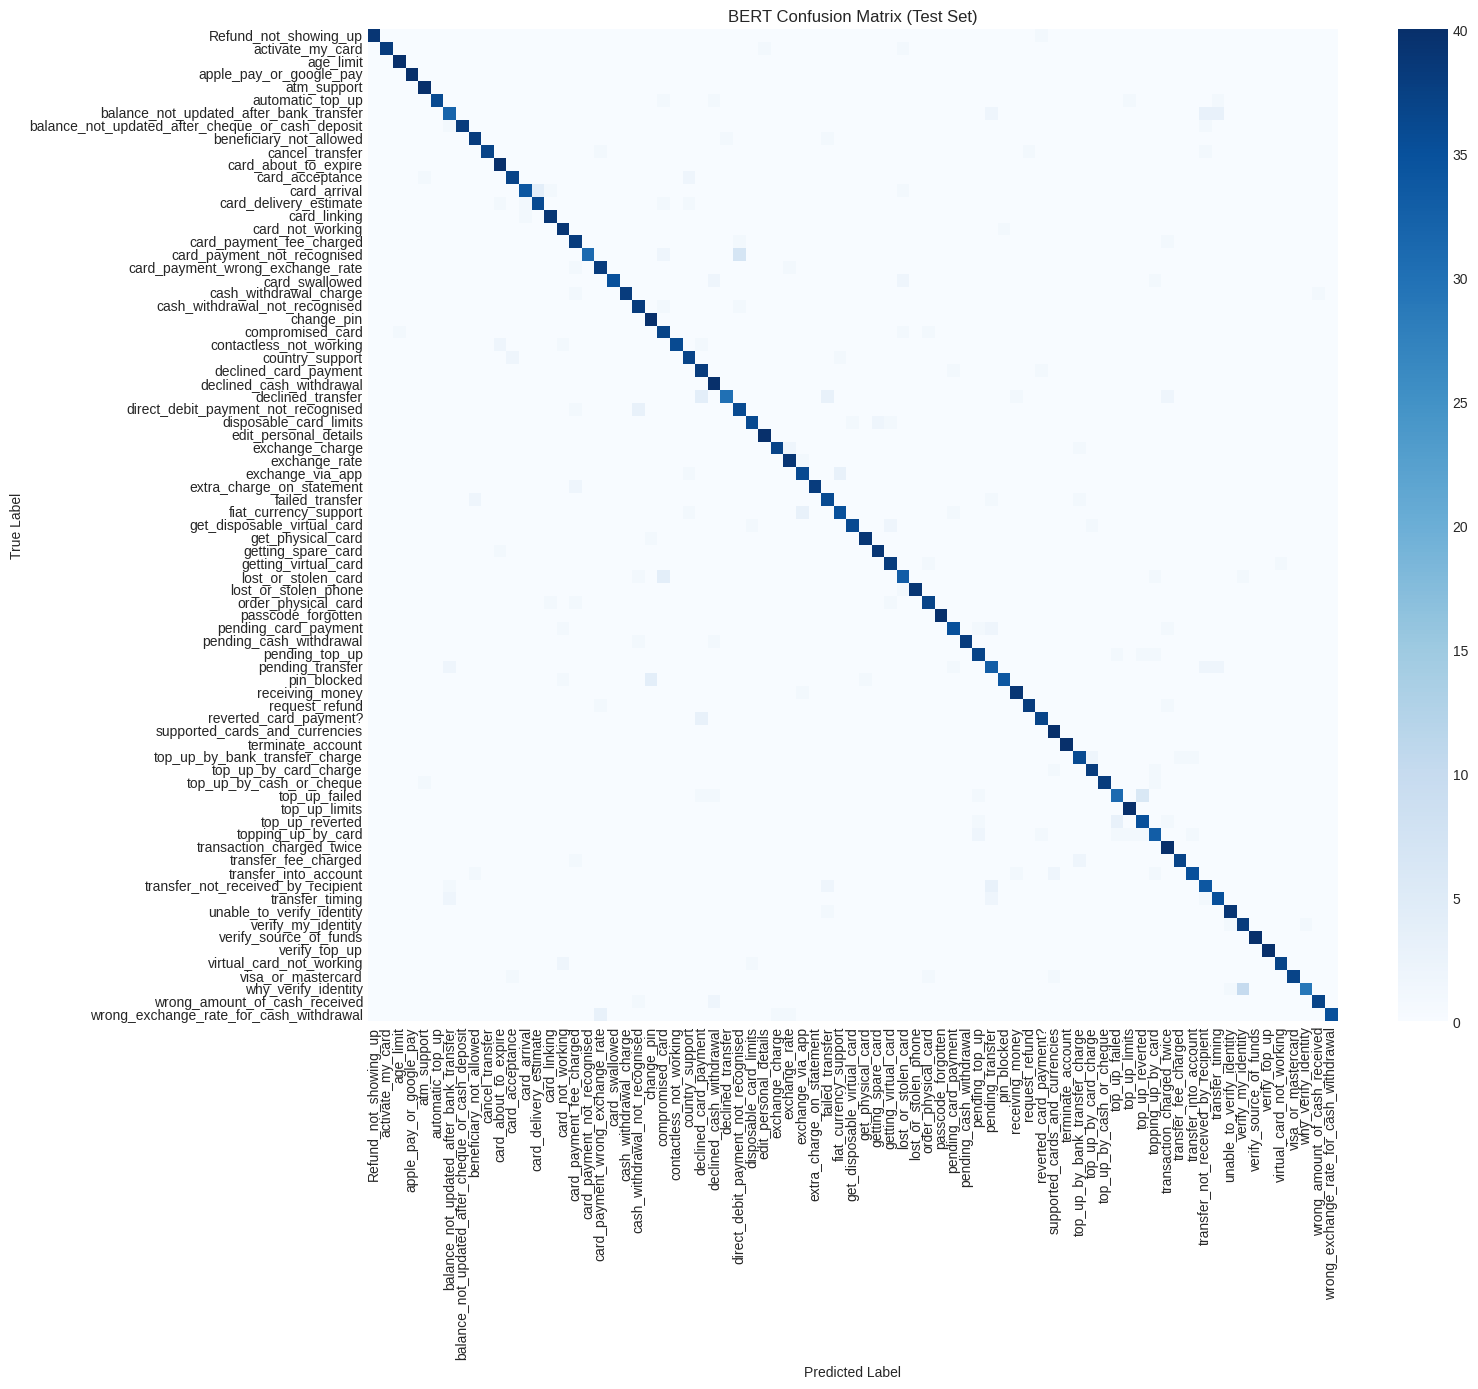

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test_bert, y_pred_bert)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=False,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BERT Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The confusion matrix above provides a detailed look at the BERT model's performance on a per-class basis.

Since there are many classes (77), the matrix can appear dense. Each cell `(i, j)` in the matrix indicates the number of samples from true class `i` that were predicted as class `j`.

- **Diagonal elements** represent correctly classified samples for each intent.
- **Off-diagonal elements** indicate misclassifications. For example, a non-zero value in row `i`, column `j` means that samples from true intent `i` were incorrectly classified as intent `j`.

To better analyze specific misclassifications or the performance of individual classes, you can zoom in on parts of the plot or refer to the `classification_report` generated earlier, which provides precision, recall, and F1-score for each class.

## 9. Save Models

In [36]:
# Save BERT model (Hugging Face format for Streamlit)
print("Saving BERT model...")

bert_model.save_pretrained('saved_models/bert_banking_intent')
tokenizer.save_pretrained('saved_models/bert_banking_intent')

print("BERT model and tokenizer saved to: saved_models/bert_banking_intent/")

Saving BERT model...
BERT model and tokenizer saved to: saved_models/bert_banking_intent/


In [43]:
# Save best sklearn model with full pipeline
print(f"\nSaving best sklearn model: {best_sklearn_name}...")

# Create custom text preprocessor class for pipeline
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(text) for text in X]

    def _preprocess(self, text):
        text = str(text).lower()
        text = contractions.fix(text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words]
        return ' '.join(tokens)

# Get the best sklearn model's estimator (which is already trained)
best_sklearn_estimator = results[best_sklearn_name]['model']

# Create full pipeline
# Use the already trained StackingClassifier instance directly as the 'classifier' step.
# The Pipeline.fit() call will then fit the preprocessor and tfidf components,
# and pass the transformed data to the already fitted StackingClassifier for consistent pipeline behavior.
full_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)),
    ('classifier', best_sklearn_estimator)
])

# Fit on all training data (this will fit the preprocessor and tfidf, the classifier is already fitted)
print("Fitting full pipeline on training data...")
full_pipeline.fit(train_df['text'], train_df['label'])

# Save pipeline and label encoder
joblib.dump(full_pipeline, 'saved_models/best_sklearn_model.pkl')
joblib.dump(label_encoder, 'saved_models/label_encoder.pkl')

print(f"Sklearn pipeline saved to: saved_models/best_sklearn_model.pkl")
print(f"Label encoder saved to: saved_models/label_encoder.pkl")


Saving best sklearn model: Stacking Classifier...
Fitting full pipeline on training data...
Sklearn pipeline saved to: saved_models/best_sklearn_model.pkl
Label encoder saved to: saved_models/label_encoder.pkl


In [44]:
# Save model comparison results
results_df.to_csv('saved_models/model_comparison.csv', index=False)
print("\nModel comparison saved to: saved_models/model_comparison.csv")

# List all saved files
print("\n" + "="*50)
print("SAVED MODEL FILES")
print("="*50)
for root, dirs, files in os.walk('saved_models'):
    level = root.replace('saved_models', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')


Model comparison saved to: saved_models/model_comparison.csv

SAVED MODEL FILES
saved_models/
  model_comparison.csv
  best_sklearn_model.pkl
  label_encoder.pkl
  bert_banking_intent/
    vocab.txt
    special_tokens_map.json
    model.safetensors
    config.json
    tokenizer_config.json


## 10. Inference Demo

In [45]:
# Demo: Load and test sklearn model
print("Loading sklearn model for inference...")

loaded_pipeline = joblib.load('saved_models/best_sklearn_model.pkl')
loaded_encoder = joblib.load('saved_models/label_encoder.pkl')

# Test samples
test_texts = [
    "I want to transfer money to another account",
    "My card was declined at the store",
    "How do I change my PIN number?",
    "I lost my credit card yesterday",
    "What's my current account balance?"
]

print("\nSklearn Model Predictions:")
print("-" * 60)
for text in test_texts:
    pred = loaded_pipeline.predict([text])[0]
    intent = loaded_encoder.inverse_transform([pred])[0]
    print(f"Text: {text}")
    print(f"Intent: {intent}\n")

Loading sklearn model for inference...

Sklearn Model Predictions:
------------------------------------------------------------
Text: I want to transfer money to another account
Intent: transfer_into_account

Text: My card was declined at the store
Intent: declined_card_payment

Text: How do I change my PIN number?
Intent: change_pin

Text: I lost my credit card yesterday
Intent: card_arrival

Text: What's my current account balance?
Intent: balance_not_updated_after_bank_transfer



In [46]:
# Demo: Load and test BERT model
print("Loading BERT model for inference...")

from transformers import BertForSequenceClassification, BertTokenizer
import torch

loaded_bert = BertForSequenceClassification.from_pretrained('saved_models/bert_banking_intent')
loaded_tokenizer = BertTokenizer.from_pretrained('saved_models/bert_banking_intent')
loaded_bert = loaded_bert.to(device)
loaded_bert.eval()

def predict_bert(text):
    """Predict intent using BERT model."""
    inputs = loaded_tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = loaded_bert(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return loaded_encoder.inverse_transform([pred])[0]

print("\nBERT Model Predictions:")
print("-" * 60)
for text in test_texts:
    intent = predict_bert(text)
    print(f"Text: {text}")
    print(f"Intent: {intent}\n")

Loading BERT model for inference...

BERT Model Predictions:
------------------------------------------------------------
Text: I want to transfer money to another account
Intent: transfer_into_account

Text: My card was declined at the store
Intent: declined_card_payment

Text: How do I change my PIN number?
Intent: change_pin

Text: I lost my credit card yesterday
Intent: compromised_card

Text: What's my current account balance?
Intent: balance_not_updated_after_bank_transfer



In [47]:
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"\nBest Overall Model: {best_model_name}")
print(f"Best Sklearn Model: {best_sklearn_name}")
print(f"\nModels saved in: saved_models/")
print("  - bert_banking_intent/ (BERT model + tokenizer)")
print("  - best_sklearn_model.pkl (Full pipeline)")
print("  - label_encoder.pkl (For decoding predictions)")
print("  - model_comparison.csv (Results summary)")


TRAINING COMPLETE

Best Overall Model: BERT
Best Sklearn Model: Stacking Classifier

Models saved in: saved_models/
  - bert_banking_intent/ (BERT model + tokenizer)
  - best_sklearn_model.pkl (Full pipeline)
  - label_encoder.pkl (For decoding predictions)
  - model_comparison.csv (Results summary)
